## Run in google colab
<a href="https://colab.research.google.com/github/lmanov1/HeavyMachineryAuction/blob/main/HeavyMachineryAuction.ipynb" target="_blank">         
<img src="https://colab.research.google.com/assets/colab-badge.svg" 
 target="_blank">
 title="Open this file in Google Colab" alt="Colab"/>
</a>

In [1]:
! pip install gdown
! pip install pandas
! pip install seaborn
! pip install numpy
! pip install matplotlib
! pip install scikit-learn
! pip install pathlib


import gdown
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pathlib import Path

def download_from_gdrive(url, filename):
    # Extract the file ID from the URL
    file_id = url.split('/')[-2]
    download_url = f"https://drive.google.com/uc?id={file_id}"

    # Download the file
    if Path(filename).exists():
        print(f"File '{filename}' already exists. Skipping download.")
    else:
        gdown.download(download_url, filename, quiet=False)
        print(f"File downloaded as: {filename}")

train = 'https://drive.google.com/file/d/1guqSpDv1Q7ZZjSbXMYGbrTvGns0VCyU5/view?usp=drive_link'
valid = 'https://drive.google.com/file/d/1j7x8xhMimKbvW62D-XeDfuRyj9ia636q/view?usp=drive_link'
# Example usage

download_from_gdrive(train, 'train.csv')
download_from_gdrive(valid, 'valid.csv')


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
File 'train.csv' already exists. Skipping download.
File 'valid.csv' already exists. Skipping download.


In [2]:
# functions attic - not used
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder , Normalizer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer  
from sklearn.model_selection import train_test_split
################################################
def scale(df):
    # Normalize features in all datasets
    scaler = StandardScaler()    
    print("Scaling on xtrain")    
    return pd.DataFrame(scaler.fit_transform(df))

################################################
def normalize(df):
    # Normalize features in all datasets
    normalizer = Normalizer()
    print("Normalizing on xtrain")
    return pd.DataFrame(normalizer.fit_transform(df))
    
################################################
def fit_pipeline_data(X_train, y_train, df ):   
    numeric_features = df.select_dtypes(exclude=['object']).columns
    categorical_features = df.select_dtypes(include=['object']).columns
    
    # Pipeline including preprocessing and model training
    pipeline = Pipeline(steps=[
        ('preprocessor', ColumnTransformer(transformers=[
            ('num', SimpleImputer(strategy='mean'), numeric_features),
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('label_encoder', ColumnTransformer(
                    transformers=[('label', LabelEncoder(), categorical_features)],
                    remainder='passthrough'
                ))
            ]), categorical_features)
        ])),
        ('regressor', RandomForestRegressor(random_state=42))
    ])

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)       
    return pipeline


################################################
def hyperparameter_tuning(xtrain, ytrain):
    # Initialize the Random Forest Regressor
    reg = RandomForestRegressor(n_jobs=8,random_state=43)

    # Define hyperparameters to search
    param_grid = {
        'n_estimators': [42, 100 ,200],
        'max_depth': [10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    }
    # param_grid = {
    #     'n_estimators': [100, 200, 300],             # Number of trees in the forest
    #     'max_features': ['auto', 'sqrt', 'log2'],    # Number of features to consider at each split
    #     'max_depth': [None, 10, 20, 30],              # Maximum depth of the trees
    #     'min_samples_split': [2, 5, 10],              # Minimum samples required to split an internal node
    #     'min_samples_leaf': [1, 2, 4],                # Minimum samples required to be at a leaf node
    #     'bootstrap': [True, False],                    # Whether bootstrap samples are used
    #     'criterion': ['squared_error', 'absolute_error']                   # Function to measure the quality of a split
    #     #{'absolute_error', 'friedman_mse', 'squared_error', 'poisson'}
    # }
    
    # Perform grid search
    grid_search = GridSearchCV(reg, param_grid, cv=5, scoring='neg_mean_squared_error')    
    print("Fitting  reg_best on xtrain, ytrain" , xtrain.shape, ytrain.shape)

    grid_search.fit(xtrain, ytrain)
    print("Fitted")
    # Get the best hyperparameters
    best_params = grid_search.best_params_
    print("Best params from regression: " , best_params)
    return best_params


/tmp/ipykernel_512033/1691877007.py:111: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  original_dataset = pd.read_csv('train.csv')


(261028, 15) (11573, 15) (111870, 15)


/tmp/ipykernel_512033/1691877007.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_data['ProductGroup'] = relevant_data['ProductGroup'].astype('category').cat.codes


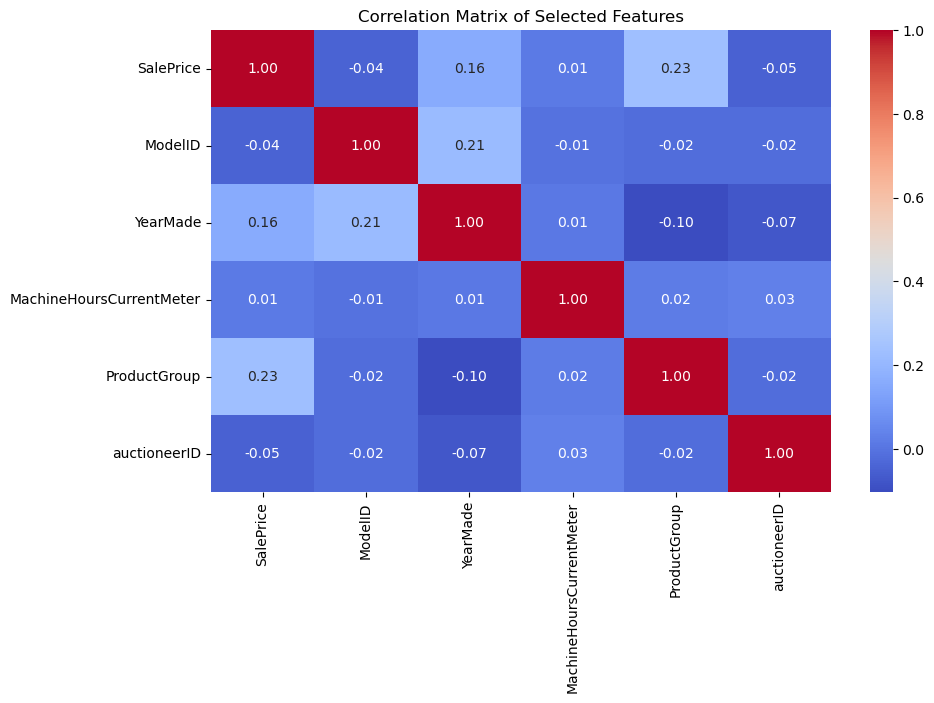

Top 4 most influential features for predicting SalePrice: ['ProductGroup', 'YearMade', 'MachineHoursCurrentMeter', 'ModelID']
 Best train RMSE: 5491.48 | ytrain.std()=23108.95 | ytrain.mean()=31349.37 
 Best test RMSE: 7601.66 | y_test.std()=23108.95 | y_test.mean()=31349.37 
Feature importances in descending order: 
 Age                         0.196496
fiProductClassDesc          0.138859
fiSecondaryDesc             0.135735
ProductSize                 0.125995
fiModelDesc                 0.114053
ModelID                     0.096303
YearMade                    0.060540
SaleYear                    0.031696
ProductGroupDesc            0.031068
ProductGroup                0.028476
state                       0.016559
auctioneerID                0.008253
fiModelSeries               0.007948
MachineHoursCurrentMeter    0.006791
UsageBand                   0.001229
dtype: float64


In [20]:
# run here
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder , Normalizer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer  
from sklearn.model_selection import train_test_split
import seaborn  as sns
import numpy as np

################################################
def RMSE(y_pred, y_true):
    return ((y_pred - y_true) ** 2).mean() ** 0.5

################################################
def train_random_forest(model , X, y=None, title="Training set"):  
    model = RandomForestRegressor(random_state=43, max_depth=20, min_samples_split=10 , n_estimators=200)
    # 1. Fit model and make predictions on the xtrain dataset
    model.fit(X, y)
    # Make predictions on the training and test sets
    y_pred = model.predict(X)
    if y is None:
        return y_pred
    
    rmse = RMSE(y_pred, y)    
    print(f" Best {title} RMSE: {rmse:.2f} | y_test.std()={y.std():.2f} | y_test.mean()={y.mean():.2f} ")        
    return rmse

from matplotlib import pyplot as plt
def visualize_corr_matrix(data):
    #relevant_columns = ['SalePrice', 'MachineHoursCurrentMeter', 'YearMade', 'ProductGroup']
    relevant_columns = ['SalePrice', 'ModelID','YearMade','MachineHoursCurrentMeter','ProductGroup','auctioneerID']
    relevant_data = data[relevant_columns]

    # Convert categorical data to numerical using Label Encoding for 'ProductGroup'
    relevant_data['ProductGroup'] = relevant_data['ProductGroup'].astype('category').cat.codes

    # Perform correlation analysis
    correlation_matrix = relevant_data.corr()

    # Identify top 3 most influential features based on correlation with SalePrice
    correlation_with_saleprice = correlation_matrix['SalePrice'].sort_values(ascending=False)
    top_features = correlation_with_saleprice.index[1:5]  # Exclude SalePrice itself

    # Visualize the correlation matrix using a heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix of Selected Features')
    plt.show()

    # Print the top 4 most influential features
    print('Top 4 most influential features for predicting SalePrice:', list(top_features))


################################################

def preprocess_data(df):    
    df2 = df.copy()

    columns_to_keep = ['SalesID', 'SalePrice', 'saledate', 'MachineID', 'ModelID','YearMade','MachineHoursCurrentMeter','ProductSize','ProductGroup',\
                       'ProductGroupDesc','fiSecondaryDesc','fiModelSeries','fiProductClassDesc','fiModelDesc','UsageBand','state',\
                       'auctioneerID']
    
    # Verification data set has no SalePrice column
    if 'SalePrice' not in df2.columns:
        columns_to_keep.remove('SalePrice')

    # IS_OROPS , as tuns out - important feature????

    # These columns (out of columns_to_keep) have mixed datatypes, so we convert them to strings
    df2['fiModelDescriptor'] = df2['fiModelDesc'].astype('str')
    df2['fiModelSeries']=df2['fiModelSeries'].astype('str')

    # Drop columns that are not in columns_to_keep    
    df2=df2[columns_to_keep]
    
    # handle dates
    df2['Saledate'] = pd.to_datetime(df2.saledate)
                
    # Feature engineering with dates
    df2['SaleYear'] =  df2['Saledate'].dt.year    
    # Those columns are not very usefull on model
    #df2['SaleMonth'] =  df2['Saledate'].dt.month
    #df2['SaleDay'] =  df2['Saledate'].dt.day     # sunday sells?  
    # Replace values in YearMade column with YearFromSaledate if YearMade is before 1900 or exceeds the sale date
    df2.loc[(df2['YearMade'] <= 1900) | (df2['YearMade'] > df2['SaleYear']), 'YearMade'] = df2['SaleYear']   
    ##df2['YearMade'] = np.where(df2['YearMade'] < 1991, 1991, df2['YearMade']) 
    df2['Age'] = df2['Saledate'].dt.year - df2['YearMade']

    # machineid is a unique identifier, so we drop it
    # sale date is redundant now, so we'll drop it
    df2 = df2.drop(columns=['saledate'] , axis=1)
    df2 = df2.drop(columns=['Saledate'] , axis=1)
    df2 = df2.drop(columns=['MachineID'], axis=1)
    
    # Finally , set index to SalesID
    df2 = df2.set_index('SalesID')    
    # df2 = df2.drop(columns=['ModelID'])  # don't touch this one !  
    # df2.fillna(df2.mode().iloc[0], inplace=True) - done in the pipeline
    return df2


# Load the original dataset 
original_dataset = pd.read_csv('train.csv')
# Preprocess the original dataset
original_dataset = preprocess_data(original_dataset)
original_dataset.drop_duplicates(inplace=True)
# Load the validation dataset 
validation_dataset = pd.read_csv('valid.csv')
# Preprocess the validation dataset
validation_dataset = preprocess_data(validation_dataset)

# Separate features and target from the original dataset
X = original_dataset.drop('SalePrice', axis=1)
y = original_dataset['SalePrice']

#From here########################################################
#X_small = X.sample(20000, random_state=43)
#X_small = X.head(50000)
X_small = X
y_small = y.loc[X_small.index]

xtrain, xtest, ytrain, ytest = train_test_split(X_small, y_small, test_size=0.3, random_state=43)
numeric_features = X.select_dtypes(exclude=['object']).columns
categorical_columns = X.select_dtypes(include=['object']).columns

# --------------Impute missing values in the train, test and validation datasets------------------------------
mostFreqImputer  = SimpleImputer(strategy='most_frequent')
meanImputer  = SimpleImputer(strategy='mean')
scaler = StandardScaler().set_output(transform="pandas")

xtrain[numeric_features]= meanImputer.fit_transform(xtrain[numeric_features])
xtrain[categorical_columns]= mostFreqImputer.fit_transform(xtrain[categorical_columns])
xtrain[numeric_features]= scaler.fit_transform(xtrain[numeric_features])

xtest[numeric_features]= meanImputer.transform(xtest[numeric_features])
xtest[categorical_columns]= mostFreqImputer.transform(xtest[categorical_columns])
xtest[numeric_features]= scaler.transform(xtest[numeric_features])

validation_dataset[numeric_features] = meanImputer.transform(validation_dataset[numeric_features])
validation_dataset[categorical_columns] = mostFreqImputer.transform(validation_dataset[categorical_columns])
validation_dataset[numeric_features]= scaler.transform(validation_dataset[numeric_features])

# --------------Label encoding on the train, test and validation datasets------------------------------
#Combine train , test and validation datasets for label encoding to keep label consistency between'em
combined_dataset = pd.concat([xtrain, validation_dataset, xtest], ignore_index=True)
# Label encode categorical features
for col in categorical_columns:
    le = LabelEncoder()
    combined_dataset[col] = le.fit_transform(combined_dataset[col].astype(str))    
# Split back into train, test and validation datasets
xtrain = combined_dataset.iloc[:len(xtrain)]
validation_dataset_encoded = combined_dataset.iloc[len(xtrain):len(validation_dataset)+len(xtrain)]
xtest = combined_dataset.iloc[len(xtrain)+ len(validation_dataset):]
print(xtrain.shape, validation_dataset.shape, xtest.shape)
xtest.to_csv(f'X_test.csv')
xtrain.to_csv(f'X_train.csv')


visualize_corr_matrix(original_dataset)
# ------------FROM HERE Train model and predict on different data sets  -------------------------
# Train with random forest regressor - parameters 20, 10, 200 are all derived from last hyperparameters tuning (uncomment the hyperparameter_tuning below if needed)
# Best params from regression:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
model = RandomForestRegressor(random_state=43, max_depth=20, min_samples_split=10 , min_samples_leaf = 1,  n_estimators=200)
# 1. Fit model and make predictions on the xtrain dataset
model.fit(xtrain, ytrain)
ytrain_pred = model.predict(xtrain)   
print(f" Best train RMSE: {RMSE(ytrain_pred, ytrain):.2f} | ytrain.std()={ytrain.std():.2f} | ytrain.mean()={ytrain.mean():.2f} ")  
#2. Make predictions on the xtest dataset
ytest_pred = model.predict(xtest)
print(f" Best test RMSE: {RMSE(ytest_pred, ytest):.2f} | y_test.std()={ytrain.std():.2f} | y_test.mean()={ytrain.mean():.2f} ")  
#Print feature importances , in descending order
print("Feature importances in descending order: \n", pd.Series(
    model.feature_importances_,
    index=model.feature_names_in_
).sort_values(ascending=False))

# Make predictions on the validation dataset
val_pred = model.predict(validation_dataset_encoded)
# ------------ TO  HERE -------------------------

# ------------ FROM HERE Determine best parameters set with grid search , than train regressor using the above set ,and predict on different data sets FROM HERE -------------------------
# Train the model with the best hyperparameters
# best_params = hyperparameter_tuning(xtrain, ytrain)
# #Best params from hyperparametrization:  {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 200}
# reg_best = RandomForestRegressor(**best_params)
# # Fit the model on the training data
# reg_best.fit(xtrain, ytrain)

# #With the best parameters , make predictions on all datasets
# # 1. Make predictions on the xtrain dataset
# print("Make predictions on the xtrain")
# ytrain_pred = reg_best.predict(xtrain)
# rmse = RMSE(ytrain_pred, ytrain)    
# print(f" Best train RMSE: {rmse:.2f} | y_test.std()={ytrain.std():.2f} | y_test.mean()={ytrain.mean():.2f} ")

# # 2. Make predictions on the xtest dataset
# print("Make predictions on the xtest and evaluate the model")
# ytest_pred = reg_best.predict(xtest)
# rmse = RMSE(ytest_pred, ytest)    
# print(f" Best test RMSE: {rmse:.2f} | y_test.std()={ytrain.std():.2f} | y_test.mean()={ytrain.mean():.2f} ")

# # 3. Make predictions on the validation dataset
# print("Make predictions on the validation dataset")
# val_pred = reg_best.predict(validation_dataset_encoded)

# # Print feature importances , in descending order
# print("Feature importances in descending order: \n", pd.Series(
#     reg_best.feature_importances_,
#     index=reg_best.feature_names_in_
# ).sort_values(ascending=False))
# ------------ TO  HERE -------------------------

# Construct a series with the predictions and the SalesID as the index for submission
val_pred = pd.Series(val_pred, index=validation_dataset.index, name='SalePrice')




In [21]:
print(val_pred.describe())
print(val_pred.head(10))
print(validation_dataset.shape)

# create file for submission
from datetime import datetime
f'submission_{datetime.now().isoformat()}'
val_pred.to_csv(f'submission_{datetime.now().isoformat()}.csv')

count     11573.000000
mean      32896.402927
std       23061.388796
min        5321.317082
25%       14795.918235
50%       25622.890679
75%       44574.808188
max      134674.292021
Name: SalePrice, dtype: float64
SalesID
1222837    51150.486620
1222839    58035.345286
1222841    32796.953703
1222843    17938.107905
1222845    38156.287798
1222847    11977.757791
1222849    23507.450452
1222850    28413.579618
1222855    80868.868674
1222863    29891.952651
Name: SalePrice, dtype: float64
(11573, 15)
